## Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def matrix_heatmap(matrix, title="", figsize=(15, 15), axis=None):
    """Plots an array of model states as a value-annotated heatmap with an arbitrary title.

    Args:
        matrix: an array of model states;
            columns representing unique feature indices and rows identifying unique update indices
        title: a title for the generated plot,
    """
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, annot=True, linewidths=0.5, ax=axis)
    plt.title(title)
    plt.xlabel("Feature Index")
    plt.ylabel("Update Index")


def instance_memory_heatmap(
    memory_state,
    pre_experimental_size=0,
    include_inputs=True,
    include_outputs=True,
    include_preexperimental=True,
):
    assert (
        include_inputs or include_outputs
    ), "At least one of inputs or outputs must be included"
    memory_shape = np.shape(memory_state)
    fig_size = list(reversed(memory_shape))
    plotted_memory = memory_state.copy()
    title = "Memory Traces"

    if not include_inputs:
        fig_size[0] /= 2  # type: ignore
        plotted_memory = plotted_memory[:, int(memory_shape[1] / 2) :]
        title = f"Output {title}"

    if not include_outputs:
        fig_size[0] /= 2  # type: ignore
        plotted_memory = plotted_memory[:, : int(memory_shape[1] / 2)]
        title = f"Input {title}"

    if not include_preexperimental:
        fig_size[1] -= pre_experimental_size
        plotted_memory = plotted_memory[int(pre_experimental_size) :]
        title = f"Experimental {title}"

    matrix_heatmap(plotted_memory, title, figsize=fig_size)

## Setup

In [3]:
from jax import numpy as jnp, lax
from jaxcmr_research.cmr.weirdcmr import BaseCMR, InstanceCMR
import json

fit_result_path = "results/icmr/Model_Fitting/HealyKahana2014_ScaleFreeBaseCMR_Model_Fitting.json"

with open(fit_result_path, "r") as f:
    fit_result = json.load(f)

base_params = {key: jnp.array(value[0]) for key, value in fit_result['fits'].items()}
base_params

{'encoding_drift_rate': Array(0.8749594, dtype=float32, weak_type=True),
 'start_drift_rate': Array(0.9224948, dtype=float32, weak_type=True),
 'recall_drift_rate': Array(0.8542432, dtype=float32, weak_type=True),
 'shared_support': Array(3.3267975, dtype=float32, weak_type=True),
 'item_support': Array(2.2029045, dtype=float32, weak_type=True),
 'learning_rate': Array(0.24711503, dtype=float32, weak_type=True),
 'primacy_scale': Array(81.65028, dtype=float32, weak_type=True),
 'primacy_decay': Array(0.03738609, dtype=float32, weak_type=True),
 'stop_probability_scale': Array(0.00329428, dtype=float32, weak_type=True),
 'stop_probability_growth': Array(0.37445745, dtype=float32, weak_type=True),
 'choice_sensitivity': Array(1., dtype=float32, weak_type=True),
 'mcf_trace_sensitivity': Array(1., dtype=float32, weak_type=True),
 'mfc_trace_sensitivity': Array(1., dtype=float32, weak_type=True),
 'mfc_choice_sensitivity': Array(1., dtype=float32, weak_type=True),
 'semantic_scale': Array(

## Memory Array Visualization

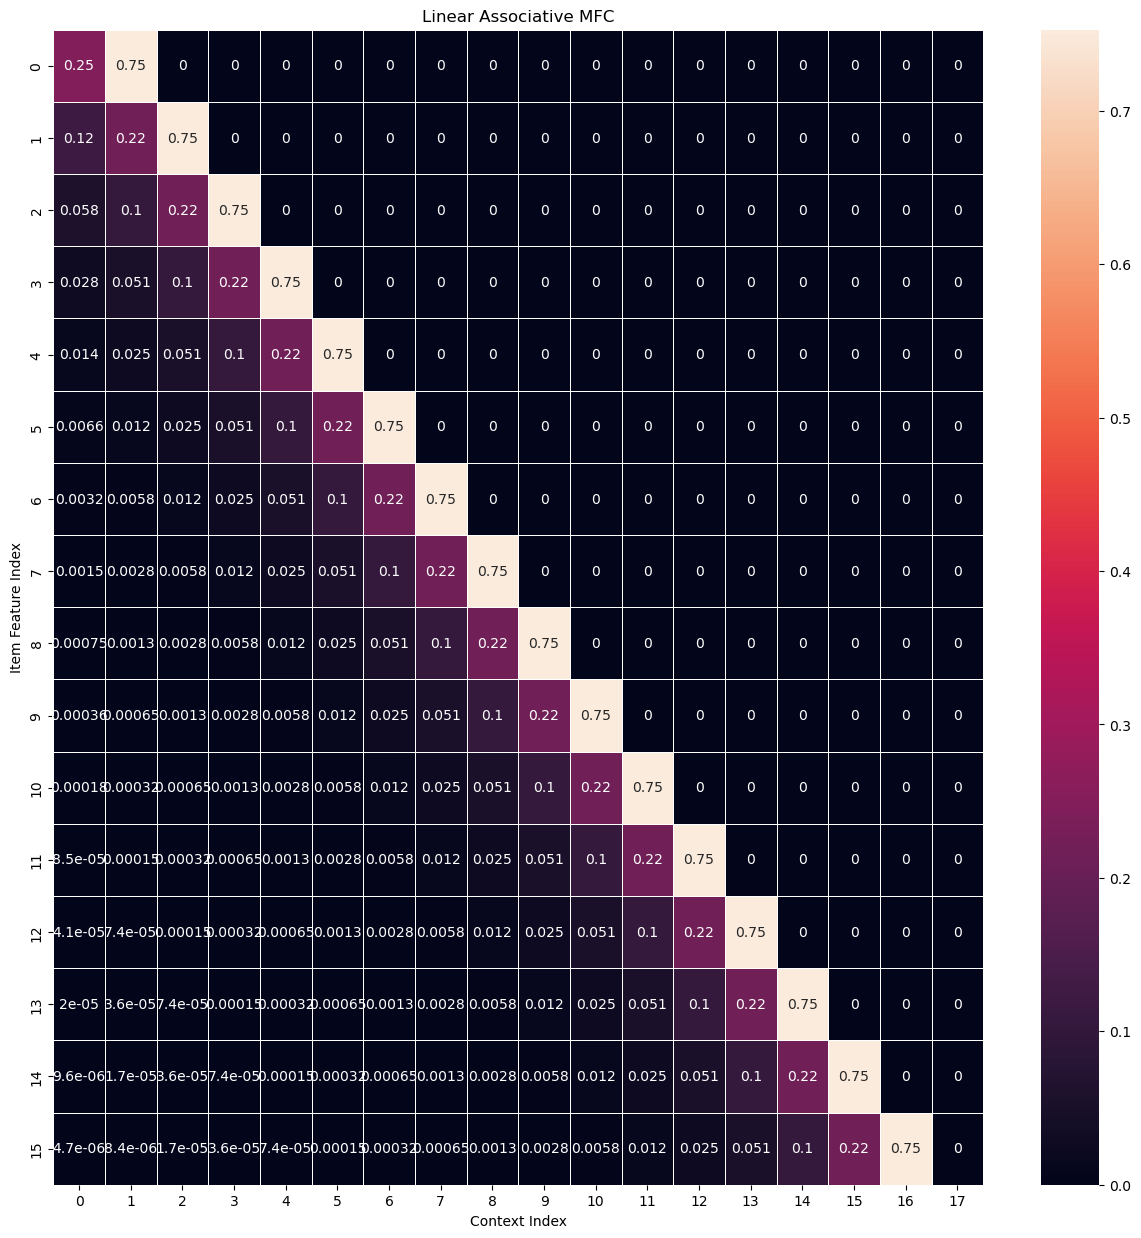

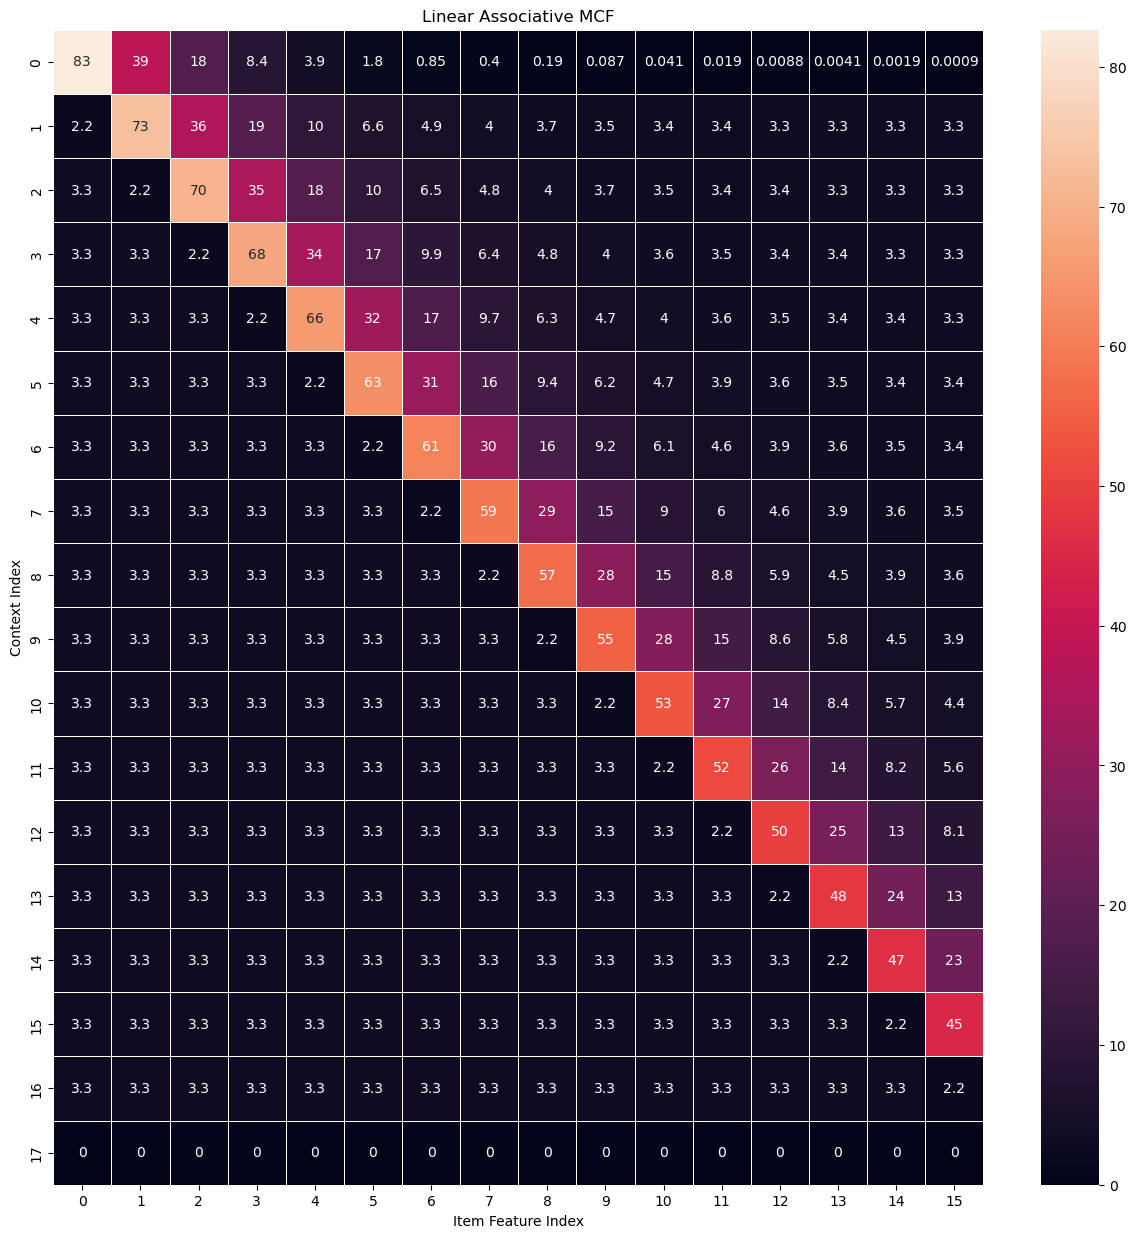

In [4]:
model_create_fn = BaseCMR
list_length = 16
parameters = base_params

model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(i + 1), model)
model = model.start_retrieving()

matrix_heatmap(model.mfc.state, title="Linear Associative MFC")
plt.xlabel("Context Index")
plt.ylabel("Item Feature Index")
plt.show()

matrix_heatmap(model.mcf.state, title="Linear Associative MCF")
plt.xlabel("Item Feature Index")
plt.ylabel("Context Index")
plt.show()

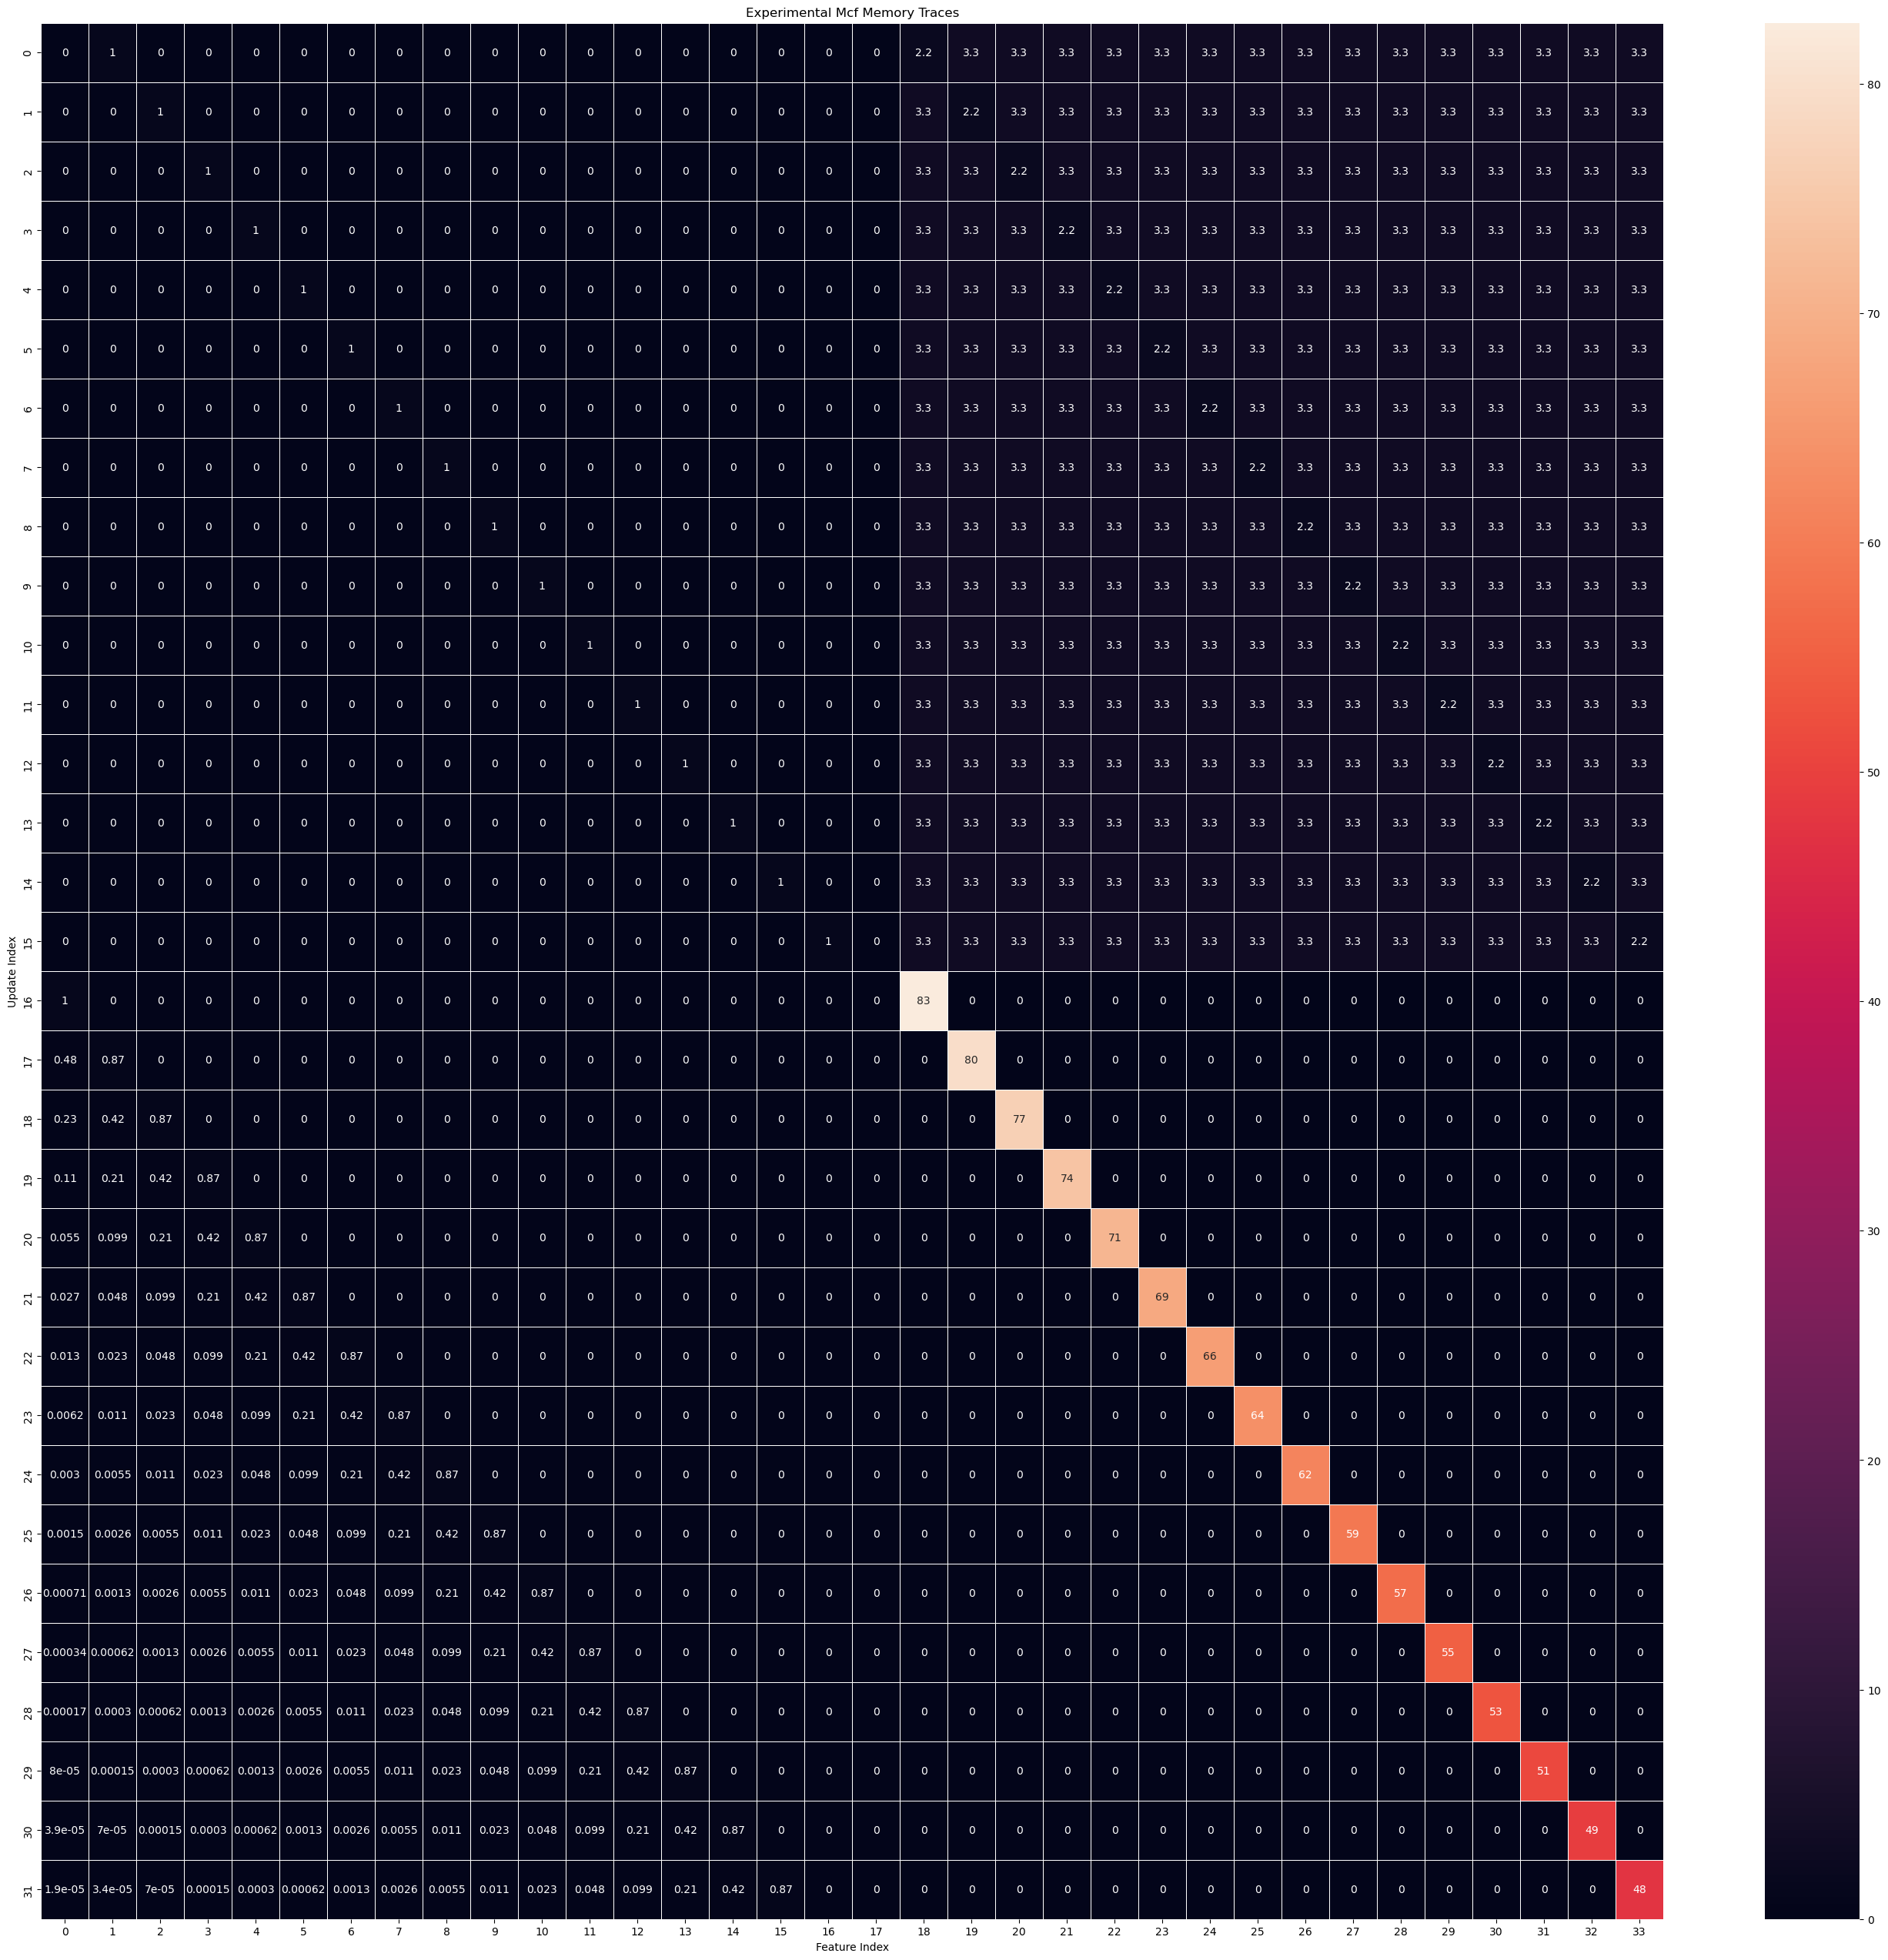

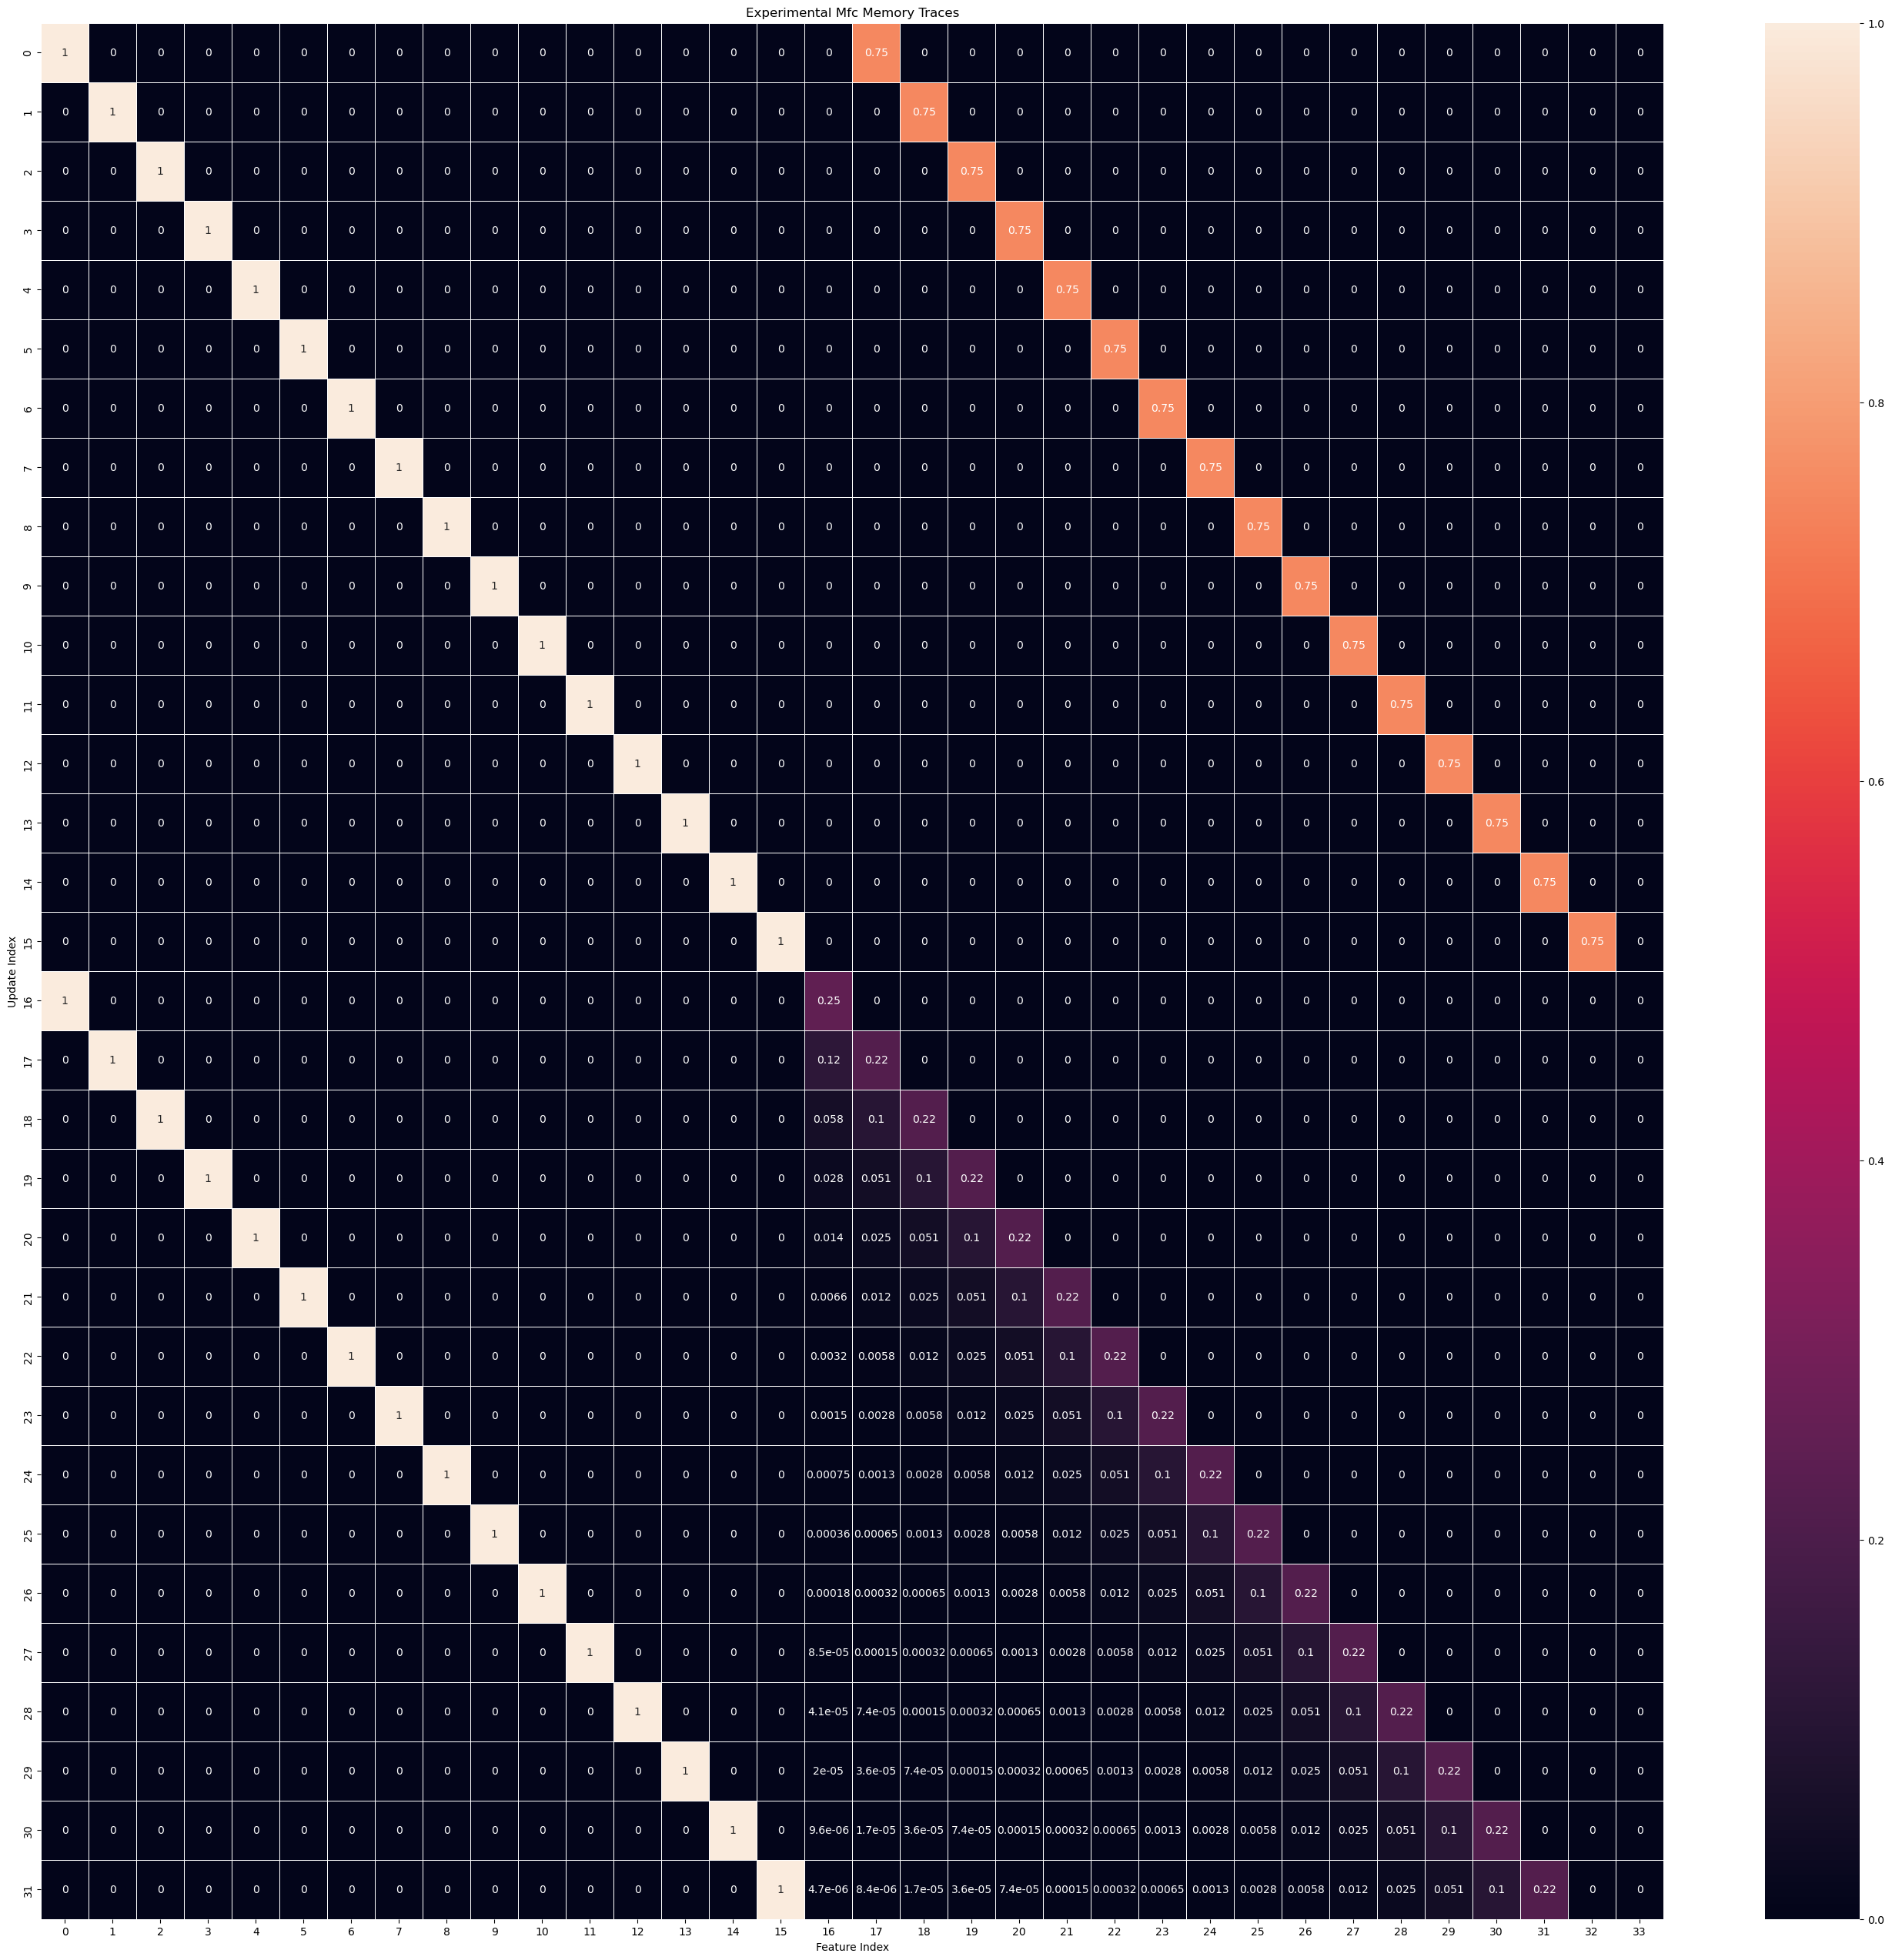

In [5]:
model_create_fn = InstanceCMR
list_length = 16
parameters = base_params

model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(i + 1), model)
model = model.start_retrieving()

instance_memory_heatmap(
    model.mcf.state,
    list_length,
    include_inputs=True,
    include_outputs=True,
    include_preexperimental=True,
)
plt.title("Experimental Mcf Memory Traces")
plt.show()

instance_memory_heatmap(
    model.mfc.state,
    list_length,
    include_inputs=True,
    include_outputs=True,
    include_preexperimental=True,
)
plt.title("Experimental Mfc Memory Traces")
plt.show()

## Latent Mfc
By probing our instance memory with each representation that can be probed with it, we can reproduce the same matrix of F->C associations as in Connectionist CMR's MFC:

In [5]:
def latent_mfc(model):
    _latent_mfc = np.zeros((model.item_count, model.item_count+2))
    for i in range(model.item_count):
        _latent_mfc[i] = model.mfc.probe(model.items[i])
    return _latent_mfc

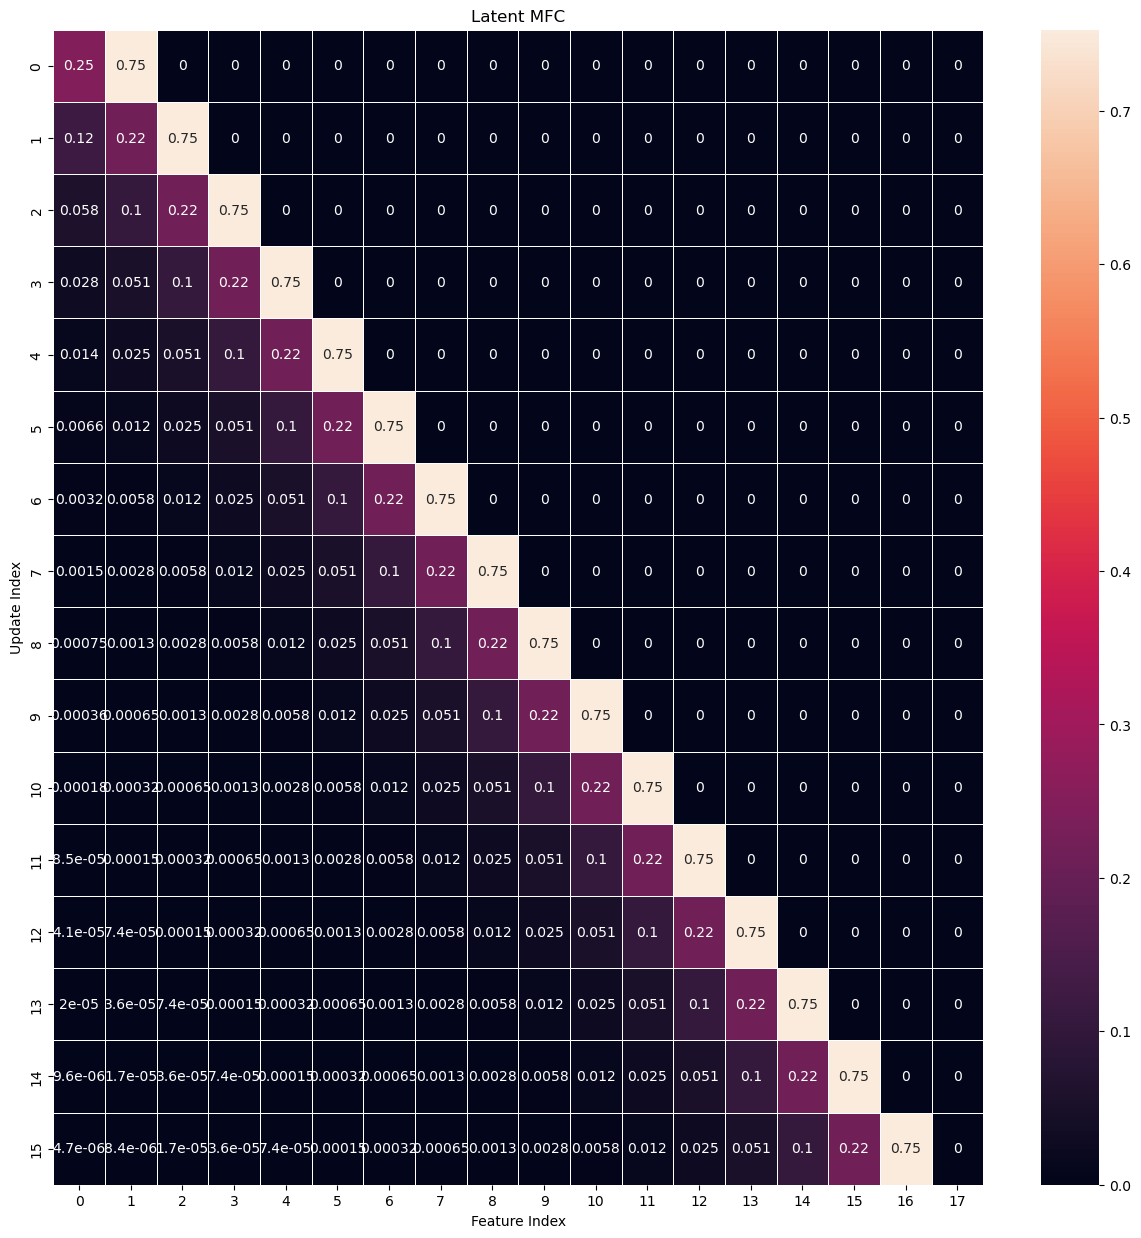

In [6]:
model_create_fn = InstanceCMR
list_length = 16
parameters = base_params

model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(i + 1), model)
model = model.start_retrieving()

matrix_heatmap(latent_mfc(model), title="Latent MFC")

## Latent Mcf

In [7]:
def latent_mcf(model):
    _latent_mcf = np.zeros((model.item_count+2, model.item_count))
    context_units = np.eye(model.item_count+2, model.item_count + 2)
    for i in range(model.item_count+2):
        _latent_mcf[i] = model.mcf.probe(context_units[i])
    return _latent_mcf


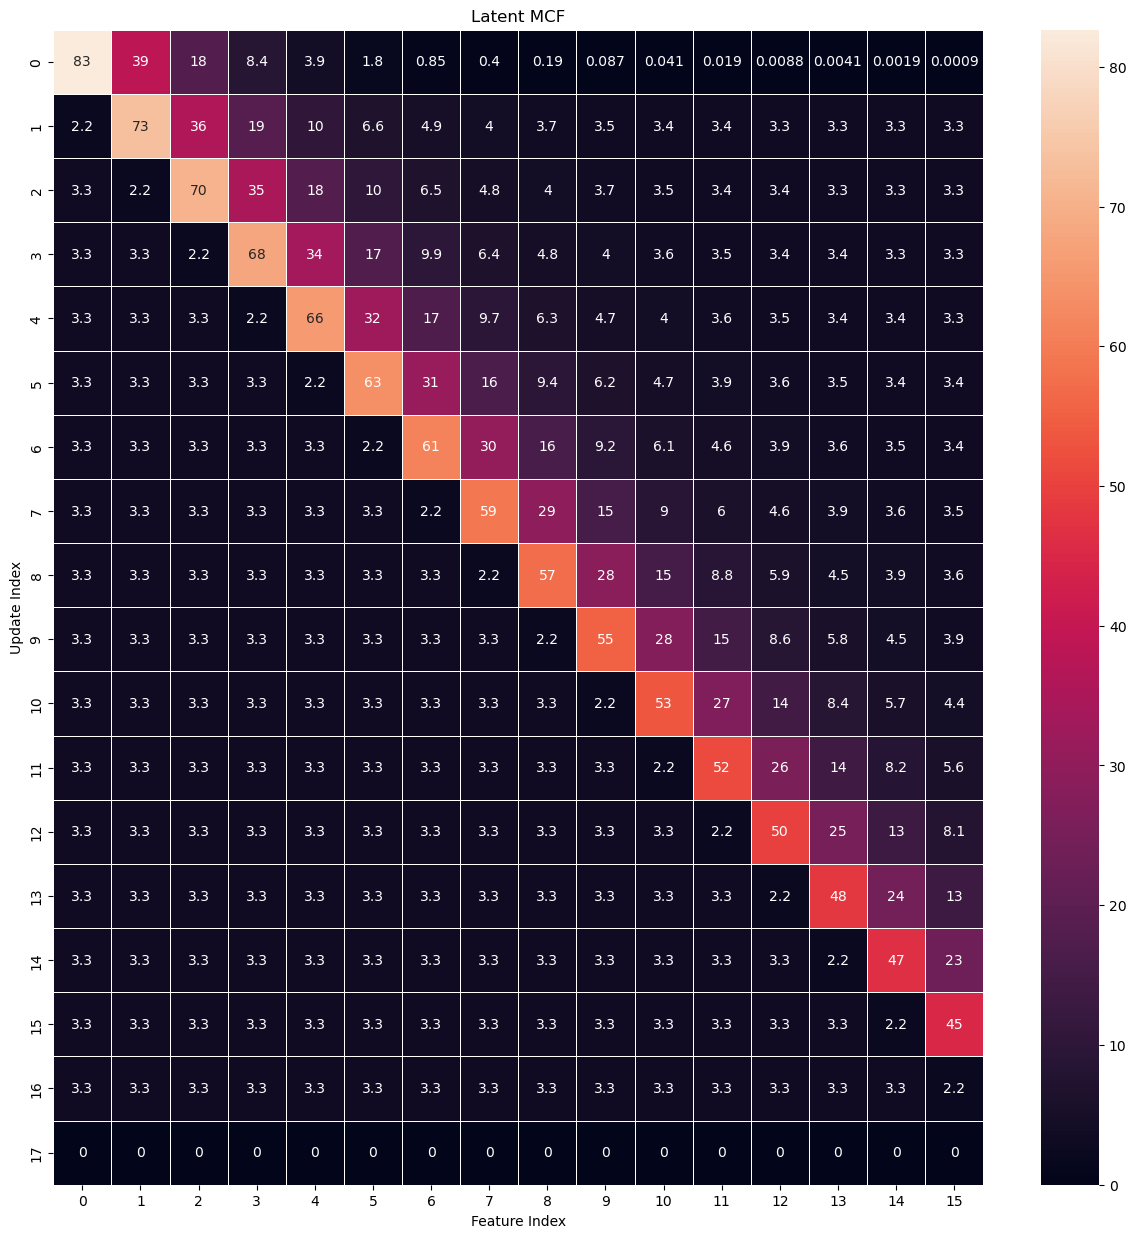

In [8]:
model_create_fn = InstanceCMR
list_length = 16
parameters = base_params

model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(i + 1), model)
model = model.start_retrieving()

matrix_heatmap(latent_mcf(model), title="Latent MCF")

## Latent Mff
By passing item representations through F->C memory and the outputs of the F->C memory through the C->F memory, we can produce a singular matrix of F->F associations in a matter agnostic to the underlying architecture.

MFF represents the associations between items in the memory, and can be used to predict how retrieving an item will shift support for retrieving other items.

In [9]:
def latent_mff(model):
    _latent_mff = np.zeros((model.item_count, model.item_count))
    _latent_mfc = latent_mfc(model)
    for i in range(model.item_count):
        _latent_mff[i] = model.mcf.probe(_latent_mfc[i])
    return _latent_mff

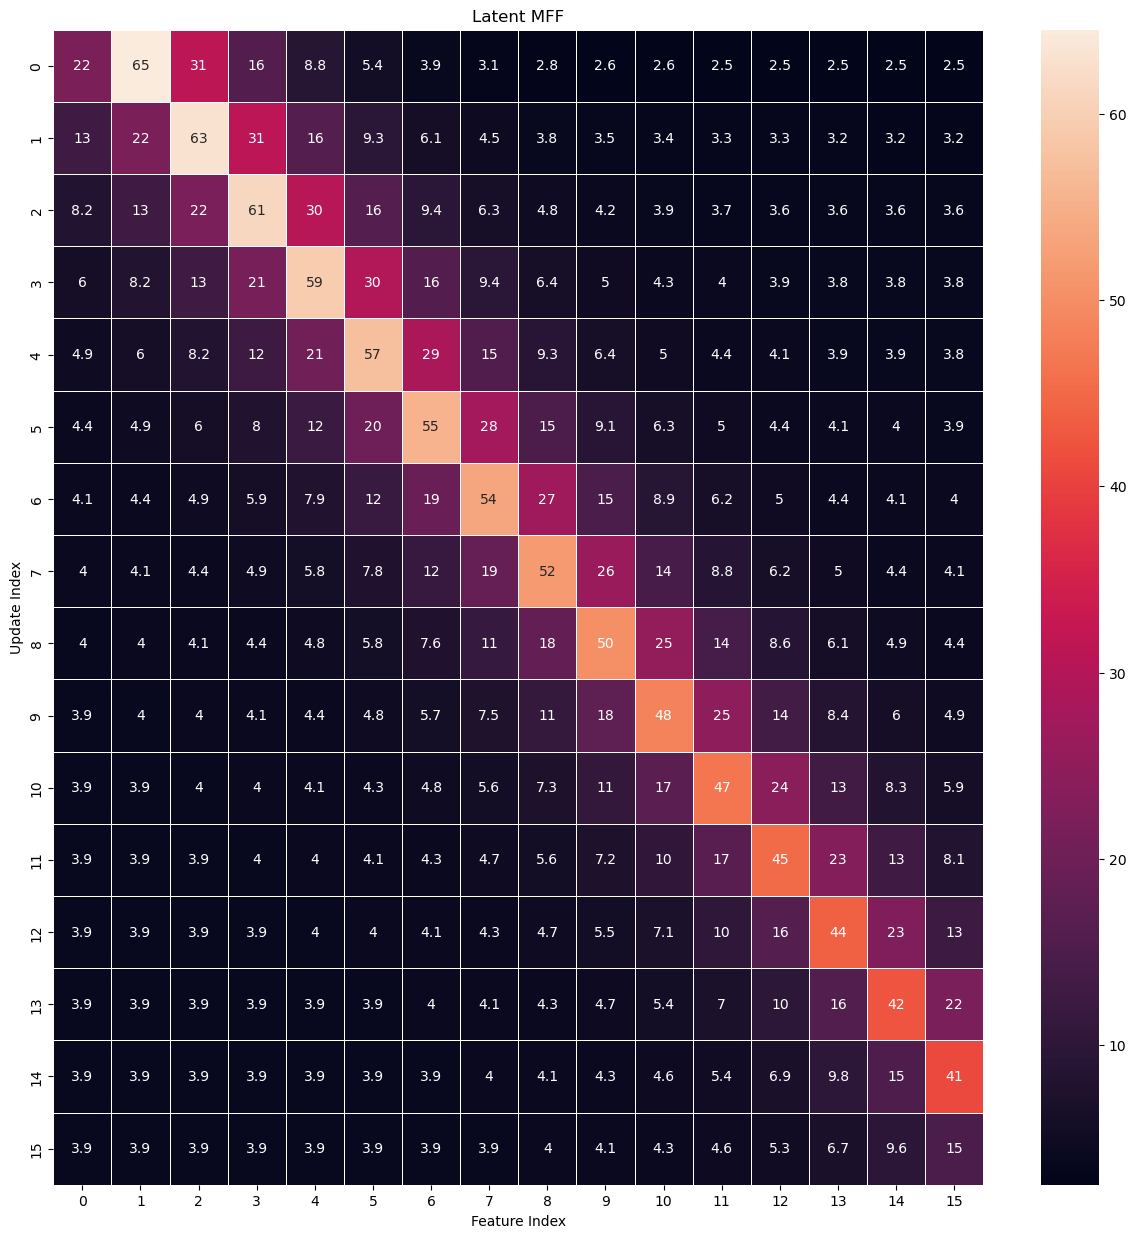

In [10]:
model_create_fn = InstanceCMR
list_length = 16
parameters = base_params

model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(i + 1), model)
model = model.start_retrieving()

matrix_heatmap(latent_mff(model), title="Latent MFF")

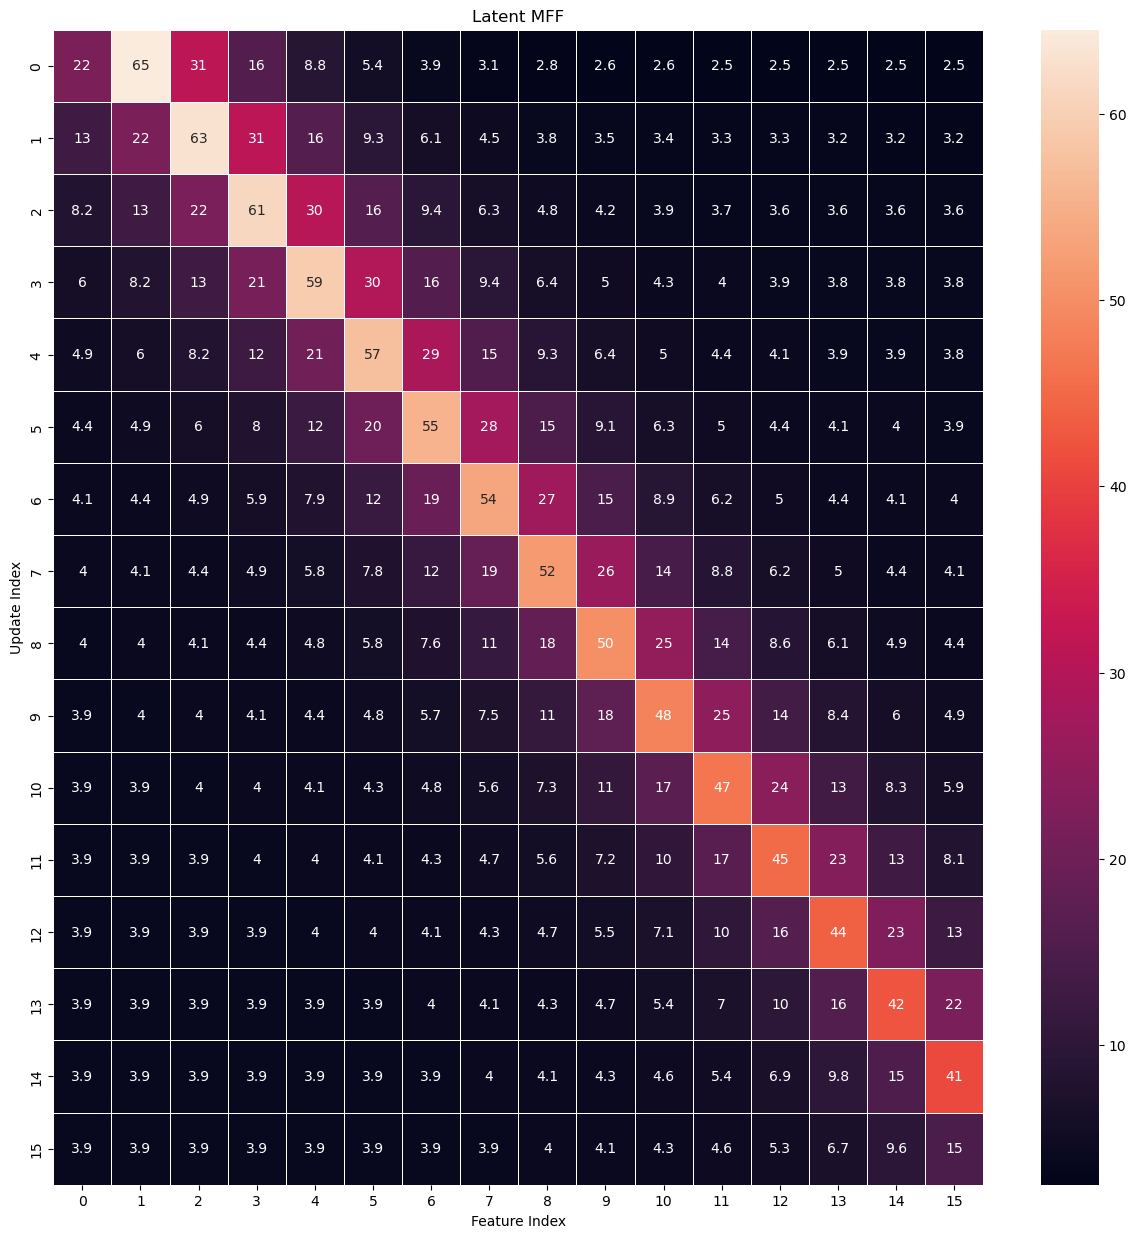

In [11]:
model_create_fn = BaseCMR
list_length = 16
parameters = base_params

model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(i + 1), model)
model = model.start_retrieving()

matrix_heatmap(latent_mff(model), title="Latent MFF")

## Memory Connectivity by Lag

To better understand our connectivity matrices, we can visualize the connectivity of the memory as a function of key variables such as the serial lag between items.

In [12]:
def connectivity_by_lag(item_connections, item_count):
    "Check out `mixed_connectivity_by_lag` for an implementation that handles flexible study order"
    
    lag_range = item_count - 1
    total_connectivity = np.zeros(lag_range * 2 + 1)
    total_possible_lags = np.zeros(lag_range * 2 + 1)
    item_positions = np.arange(item_count, dtype=int)
    
    # tabulate bin totals for actual and possible lags
    # this time instead of looping through trials and recall indices, we only loop once through each item index
    for i in range(item_count):

        # lag of each item from current item is item position - i, 
        # and will always be in range [-lag_range, lag_range] so we keep position by adding lag_range
        item_lags = item_positions - i + lag_range
        total_connectivity[item_lags] += item_connections[i]
        total_possible_lags[item_lags] += 1

    # divide by possible lags to get average connectivity
    return total_connectivity / total_possible_lags

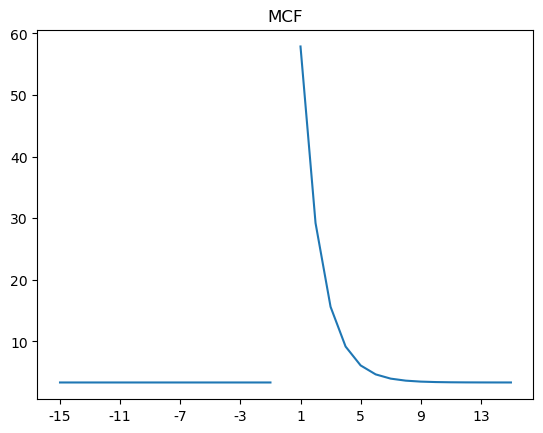

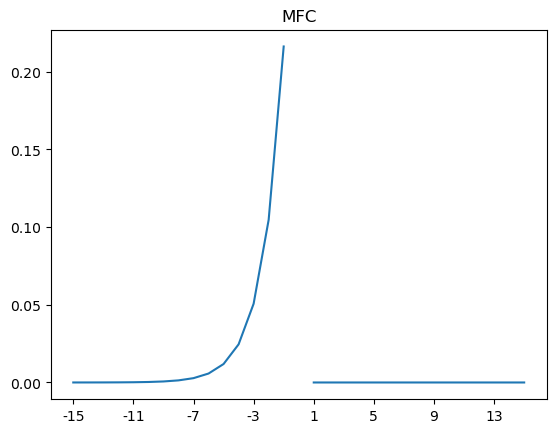

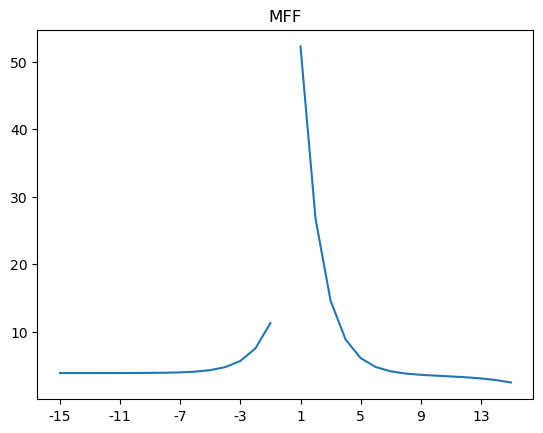

In [13]:
model_create_fn = BaseCMR
list_length = 16
parameters = base_params

model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(i + 1), model)
model = model.start_retrieving()

# MCF
fig, axis = plt.subplots(nrows=1, ncols=1)#, figsize=(15/2, 15/2), sharey=True)
mcf = latent_mcf(model)
test_crp = connectivity_by_lag(mcf[1:-1, :], model.item_count)
test_crp[model.item_count-1] = np.nan
axis.plot(np.arange(len(test_crp)), test_crp)
axis.set_xticks(np.arange(0, len(test_crp), 4))
axis.set_xticklabels(np.arange(0, len(test_crp), 4) - (model.item_count - 1))
axis.set_title('MCF')
plt.show()

# same for MFC
fig, axis = plt.subplots(nrows=1, ncols=1)#, figsize=(15/2, 15/2), sharey=True)
mfc = latent_mfc(model)
test_crp = connectivity_by_lag(mfc[:, 1:-1], model.item_count)
test_crp[model.item_count-1] = np.nan
axis.plot(np.arange(len(test_crp)), test_crp)
axis.set_xticks(np.arange(0, len(test_crp), 4))
axis.set_xticklabels(np.arange(0, len(test_crp), 4) - (model.item_count - 1))
axis.set_title('MFC');
# fig.suptitle('PrototypeCMR Item Connectivity By Lag');

# MFF
mff = latent_mff(model)
fig, axis = plt.subplots(nrows=1, ncols=1)#, figsize=(15/2, 15/2), sharey=True)
test_crp = connectivity_by_lag(mff, model.item_count)
test_crp[model.item_count-1] = np.nan
axis.plot(np.arange(len(test_crp)), test_crp)
axis.set_xticks(np.arange(0, len(test_crp), 4))
axis.set_xticklabels(np.arange(0, len(test_crp), 4) - (model.item_count - 1))
axis.set_title('MFF');

Minus-lag transitions are supported by MFC connections plus its transformation of the contextual probe to target minus-lag items. Plus-lag transitions are supported by MCF connections, especially connections between the last recalled item and its primary pre-experimental contextual unit, which is reliably activated via MFC context reinstatement.

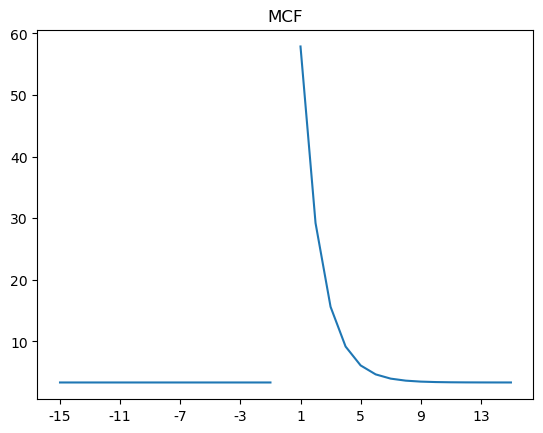

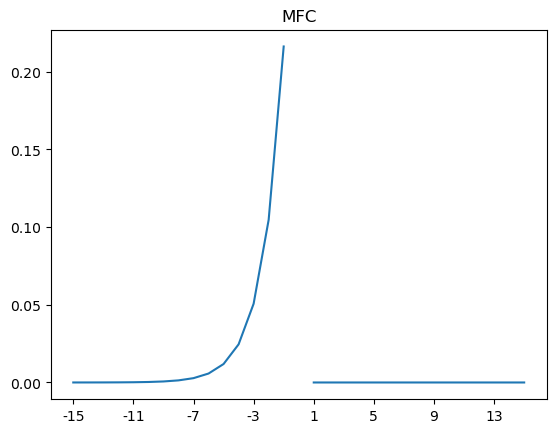

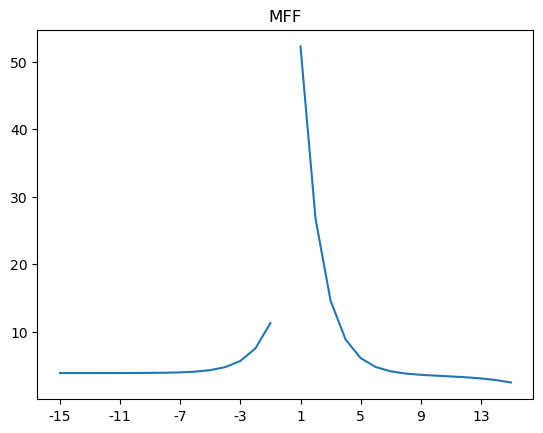

In [14]:
model_create_fn = InstanceCMR
list_length = 16
parameters = base_params

model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(i + 1), model)
model = model.start_retrieving()

# MCF
fig, axis = plt.subplots(nrows=1, ncols=1)#, figsize=(15/2, 15/2), sharey=True)
mcf = latent_mcf(model)
test_crp = connectivity_by_lag(mcf[1:-1, :], model.item_count)
test_crp[model.item_count-1] = np.nan
axis.plot(np.arange(len(test_crp)), test_crp)
axis.set_xticks(np.arange(0, len(test_crp), 4))
axis.set_xticklabels(np.arange(0, len(test_crp), 4) - (model.item_count - 1))
axis.set_title('MCF')
plt.show()

# same for MFC
fig, axis = plt.subplots(nrows=1, ncols=1)#, figsize=(15/2, 15/2), sharey=True)
mfc = latent_mfc(model)
test_crp = connectivity_by_lag(mfc[:, 1:-1], model.item_count)
test_crp[model.item_count-1] = np.nan
axis.plot(np.arange(len(test_crp)), test_crp)
axis.set_xticks(np.arange(0, len(test_crp), 4))
axis.set_xticklabels(np.arange(0, len(test_crp), 4) - (model.item_count - 1))
axis.set_title('MFC');
# fig.suptitle('PrototypeCMR Item Connectivity By Lag');

# MFF
mff = latent_mff(model)
fig, axis = plt.subplots(nrows=1, ncols=1)#, figsize=(15/2, 15/2), sharey=True)
test_crp = connectivity_by_lag(mff, model.item_count)
test_crp[model.item_count-1] = np.nan
axis.plot(np.arange(len(test_crp)), test_crp)
axis.set_xticks(np.arange(0, len(test_crp), 4))
axis.set_xticklabels(np.arange(0, len(test_crp), 4) - (model.item_count - 1))
axis.set_title('MFF');

## Memory Connectivity by Serial Position

This is less interpretable. Maybe implemented incorrectly?

In [15]:
def connectivity_by_study_position(item_connections, item_count):
    "Check out `mixed_connectivity_by_lag` for an implementation that handles flexible study order"
    
    total_connectivity = np.zeros(item_count)
    
    # tabulate bin totals for actual and possible lags
    # this time instead of looping through trials and recall indices, we only loop once through each item index
    for i in range(item_count):

        # lag of each item from current item is item position - i, 
        # and will always be in range [-lag_range, lag_range] so we keep position by adding lag_range
        total_connectivity += item_connections[i]

    # divide by possible lags to get average connectivity
    return total_connectivity

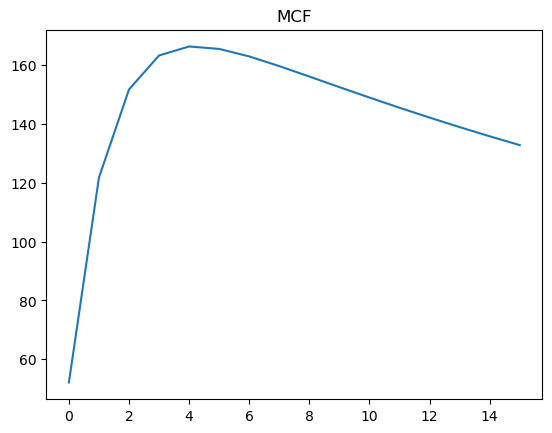

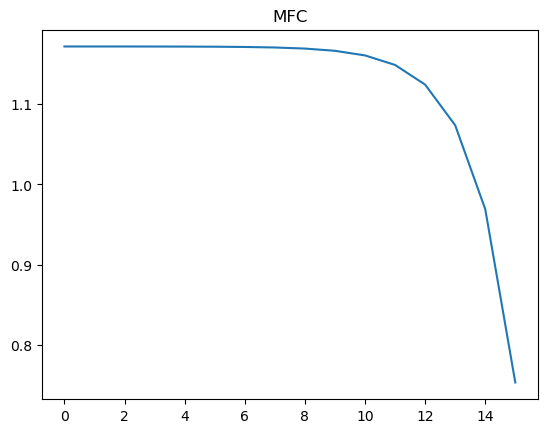

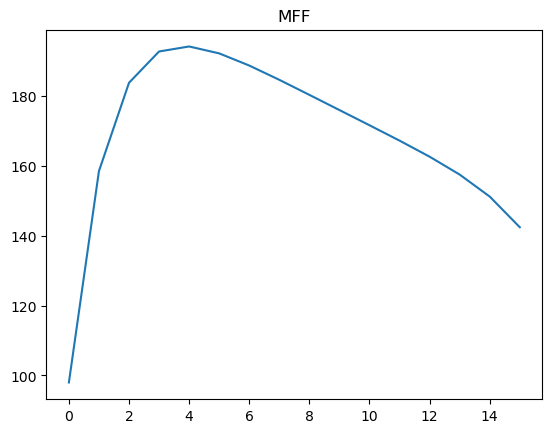

In [16]:
model_create_fn = BaseCMR
list_length = 16
parameters = base_params

model = model_create_fn(list_length, parameters)
model = lax.fori_loop(0, list_length, lambda i, m: m.experience(i + 1), model)
model = model.start_retrieving()

# MCF
fig, axis = plt.subplots(nrows=1, ncols=1)#, figsize=(15/2, 15/2), sharey=True)
mcf = latent_mcf(model)
test_spc = connectivity_by_study_position(mcf[1:-1, :], model.item_count)
axis.plot(np.arange(len(test_spc)), test_spc)
axis.set_title('MCF')
plt.show()

# same for MFC
fig, axis = plt.subplots(nrows=1, ncols=1)#, figsize=(15/2, 15/2), sharey=True)
mfc = latent_mfc(model)
test_spc = connectivity_by_study_position(mfc[:, 1:-1], model.item_count)
axis.plot(np.arange(len(test_spc)), test_spc)
axis.set_title('MFC');
# fig.suptitle('PrototypeCMR Item Connectivity By Study Position');
plt.show()

# MFF
mff = latent_mff(model)
fig, axis = plt.subplots(nrows=1, ncols=1)#, figsize=(15/2, 15/2), sharey=True)
test_spc = connectivity_by_study_position(mff, model.item_count)
axis.plot(np.arange(len(test_spc)), test_spc)
axis.set_title('MFF');
# fig.suptitle('PrototypeCMR Item Connectivity By Study Position');
plt.show()